In [8]:
import sys 
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE
from sndstraj.utils.nomenclatureUtils import get_concepts_labels, RESOURCES_PATH
import plotly.graph_objs as go
import plotly

import matplotlib.pyplot as plt
import pandas as pd
#plt.style.use('dark_background')
import json 
import re
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Une fois que l'on a obtenu des embeddings, il peut être intéressant de les visualiser. Pour cela, nous appliquons une méthode de projection en basse dimension bien adaptée à la visualisation: TSNE. TSNE cherche à fitter un modèle gaussien en 2 dimensions à un modèle gaussien des données en haute dimension. Cette technique est souvent plus adapatée que la PCA pour mettre en évidence des regroupements dans les données.

*Note:* Sur ces données de test, la méthode n'a aucun intérêt et le plot ne donnera aucun résultat intéressant. Ceci est simplement un modèle pour de vrais études.

In [9]:
d = 150
path2embeddings = '../results/coocurrence_matrix/test_snds2vec_alpha=0.75_k=1_d=5.json'
with open(path2embeddings, 'r') as f:
    embeddings_dict = json.load(f)

In [10]:
codes = list(embeddings_dict.keys())
embeddings = list(embeddings_dict.values())
embeddings_mat = np.matrix(embeddings)

### Loads and preprocess codes labels

In [11]:
concepts_labels = get_concepts_labels(codes, RESOURCES_PATH)#.set_index('concept_code')
concepts_labels['concept_terminology'].value_counts()

available terminology trees are : dict_keys(['ngap', 'atc7', 'ccam', 'cim10', 'nabm'])
(12, 3)
0 concept codes are not found in terminology trees.
0 concepts are found in more than one terminology.
Please rerun this function with verbose >=2 to get back unfound and doublons as second and third results.


atc7     8
cim10    3
ccam     1
Name: concept_terminology, dtype: int64

In [12]:
color_map = {
    'atc7': 'limegreen', 
    'cim10': 'deepskyblue', 
    'ccam': 'firebrick', 
    'nabm': 'orchid', 
    'ngap': 'yellow', 
    'unknown': 'grey'
}

concepts_labels['plotted_label'] = concepts_labels.apply(lambda x: x['concept_code'] + ' : ' + x['concept_name'], axis=1)#['concept_code']= .to_dict()
concepts_labels['plotted_color'] = concepts_labels['concept_terminology'].map(lambda x: color_map[x]).to_list()

# Reduction de dimension

# Visualisation

In [13]:
perplexity = 30
n_iter = 1000
metric='cosine'
tsne = TSNE(
    n_components=2, 
    metric=metric, 
    perplexity=perplexity, 
    early_exaggeration=15, 
    n_iter=n_iter, random_state=2)#n_jobs=40, 
X = tsne.fit_transform(embeddings_mat)

## Interactive plot

In [14]:
coordinates = pd.DataFrame({
    'concept_code': codes,
    'x': X[:, 0],
    'y': X[:, 1]
})
plotted_concepts = concepts_labels.merge(
    coordinates, 
    on='concept_code', 
    how='inner')
print(plotted_concepts.shape)
print(concepts_labels.shape)

(12, 7)
(12, 5)


In [15]:
vocabs = ['atc7', 'ccam', 'cim10', 'nabm']

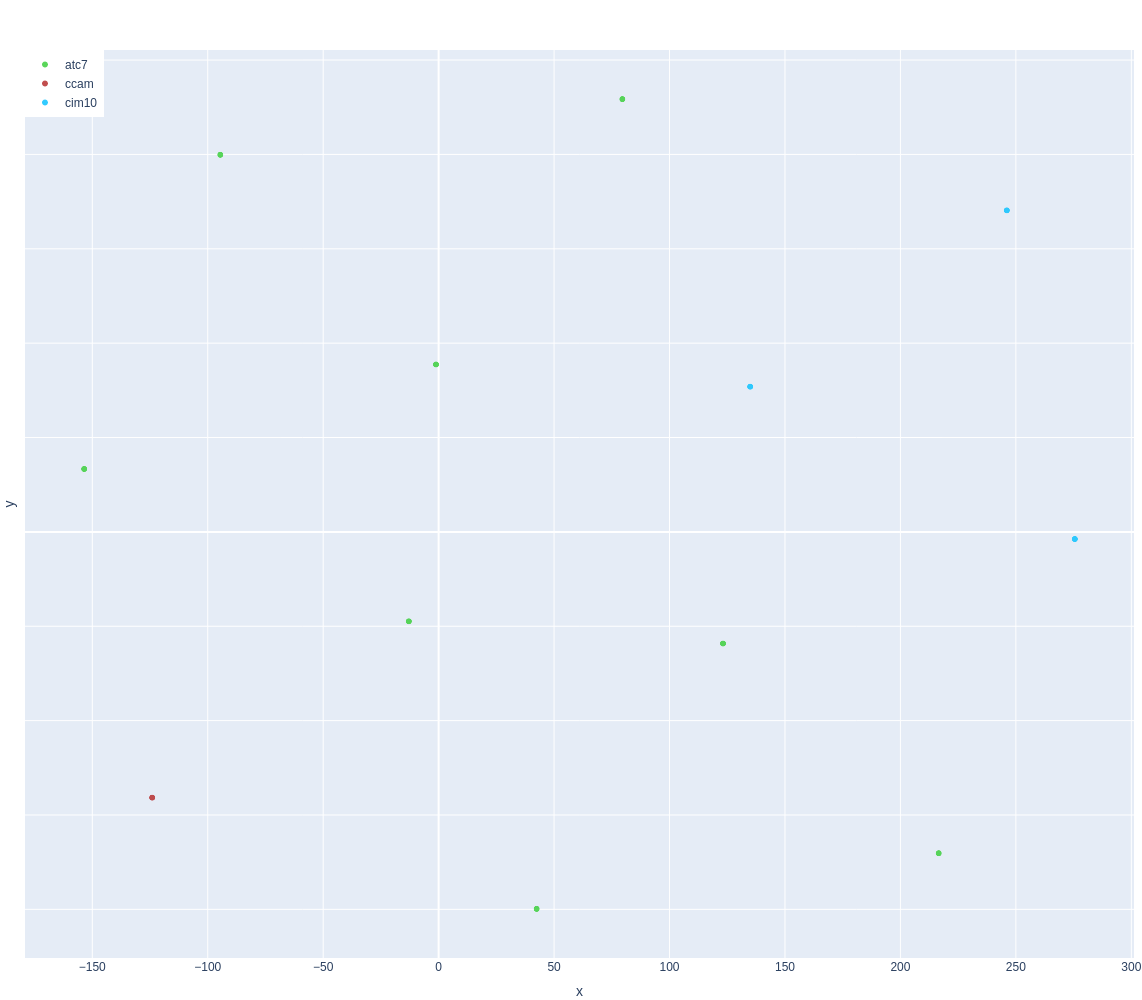

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `tsne_snds2vec_test` didn't end with .html. Adding .html to the end of your file.



'tsne_snds2vec_test.html'

In [17]:
fig = go.Figure(
    layout=dict(
        #title="{}".format('snds2vec'),
        autosize=True,
        width=1000,
        height=1000,
        xaxis={'title': 'x', 'showticklabels': True},
        yaxis={'title': 'y', 'showticklabels': False},
        margin={'l': 0, 'b': 0, 't': 50, 'r': 0},
        showlegend=True,
        hovermode='closest')
)

for vocab in vocabs:
    vocab_data = plotted_concepts.loc[plotted_concepts['concept_terminology'] == vocab, :]
    fig.add_trace(
        go.Scattergl(
            x=vocab_data['x'],
            y=vocab_data['y'],
            legendgroup="terminology",
            name=vocab,
            text=vocab_data['plotted_label'],
            mode='markers',
            opacity=0.8,
            marker={
                'size': 6,
                'color': vocab_data['plotted_color']
            })
    )

fig.update_layout(legend=dict(x=0, y=1))
config = {'scrollZoom': True}

fig.show(renderer='jupyterlab', config=config)
plotly.offline.plot(fig, filename='{}'.format('tsne_snds2vec_test'), config=config)